In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

2021-11-08 23:35:02.413512: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print(tf.__version__)

2.5.0


# Loading SIPI Dataset

SIPI dataset was preprocessed using prepare_dataset notebook, so these three folders already contain Detritus/Non-Detritus images.

In [6]:
DatasetName = 'DatasetZS'

train_dir = DatasetName+'/train'
validation_dir =  DatasetName+'/val'
test_dir = DatasetName+'/test'

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

The three datasets are loaded using keras preprocessing method *image_dataset_from_directory*. Both the batch size and the image size hyperparameters where tested using different values. 

In [8]:
train_dataset = image_dataset_from_directory(train_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 34927 files belonging to 17 classes.


2021-11-08 23:35:47.987055: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-08 23:35:48.067282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2021-11-08 23:35:48.068992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:81:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-11-08 23:35:48.069041: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-08 23:35:48.407248: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libra

Found 7472 files belonging to 17 classes.
Found 7481 files belonging to 17 classes.


# Training

In [9]:
# Hyperparamers to be used in all models
base_learning_rate = 0.0001
IMG_SHAPE = IMG_SIZE + (3,)
TRAINING_EPOCHS = 40

# MobileNet model

A MobileNet model is loaded and modified so it can be used to predict Detritus images..

In [10]:
mobile_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = mobile_base_model(image_batch)
print(feature_batch.shape)

2021-11-08 23:36:22.682007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-08 23:36:22.702265: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100090000 Hz
2021-11-08 23:36:22.992428: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-11-08 23:36:23.563839: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-11-08 23:36:24.304533: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-08 23:36:28.842037: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


(32, 5, 5, 1280)


In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 16)


In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = mobile_base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
mobilenet_model = tf.keras.Model(inputs, outputs)

# DenseNet model

In [15]:
dense_base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [16]:
preprocess_input = tf.keras.applications.densenet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = dense_base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
densenet_model = tf.keras.Model(inputs, outputs)

# VGG model

In [17]:
vgg_base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [18]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = vgg_base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
vgg_model = tf.keras.Model(inputs, outputs)

# Inception Resnet model

In [19]:
inception_base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [20]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(16)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = inception_base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
inception_resnet_model = tf.keras.Model(inputs, outputs)

# Training models

In [21]:
def train_model(model, epochs):
    print("Training model, epochs: ", epochs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    training_loss = history.history['loss']
    val_loss = history.history['val_loss']

    loss, accuracy = model.evaluate(test_dataset)
    print('Test accuracy :', accuracy)
    
    return acc, val_acc, training_loss, val_loss

In [22]:
def show_plot(acc, val_acc, loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

We test each of the 4 models from scratch. Comparing them by the testing accuracy and analyzing their Training and Validation Accuracy/Loss along the training epochs
*MobileNet = 92.5% (99% training accuracy)

In [23]:
acc, val_acc, loss, val_loss = train_model(mobilenet_model, TRAINING_EPOCHS)
show_plot(acc, val_acc, loss, val_loss)

Training model, epochs:  40
Epoch 1/40


ValueError: in user code:

    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:796 train_step
        loss = self.compiled_loss(
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:1754 binary_crossentropy
        backend.binary_crossentropy(
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:5023 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 16) vs (None, 1))


In [21]:
#acc, val_acc, loss, val_loss = train_model(densenet_model, TRAINING_EPOCHS)
#show_plot(acc, val_acc, loss, val_loss)

In [22]:
#acc, val_acc, loss, val_loss = train_model(inception_resnet_model, TRAINING_EPOCHS)
#show_plot(acc, val_acc, loss, val_loss)

** Adicionar tabela com resultados

After comparing them we choose MobileNet as it demands a smaller number of parameters to train. We use techniques in order to improve Training and Validation accuracy.

# Transfer learning with freezing

We load the model again but with pre-set imagenet weights.

In [23]:
TRAINING_EPOCHS = 20

In [24]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

preprocess_input = tf.keras.applications.densenet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

We achieve around 93% training accuracy and around 93% testing accuracy.

# Transfer learning without freezing

We load the model again but with pre-set imagenet weights.

In [25]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

preprocess_input = tf.keras.applications.densenet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

We achieve around 99% training accuracy and around 95% testing accuracy.

# Transfer learning and Fine Tuning + Regularizatoin

# Data Augmentation

This adds random transformations to the training images in order to reduce overfitting.

In [26]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

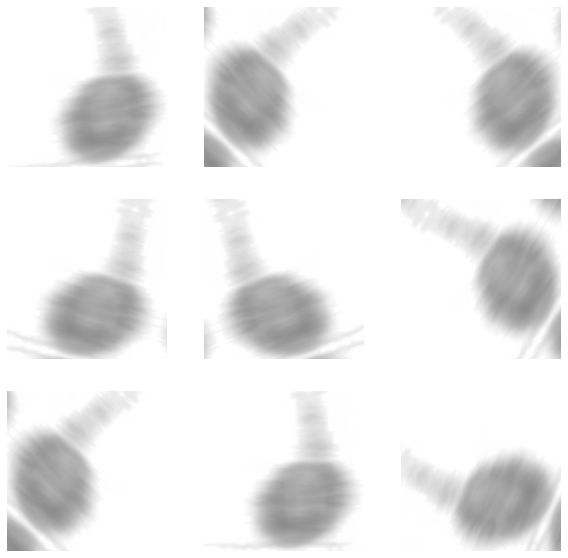

In [27]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
first_image = image[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Training

In [28]:
def train_model(model, initial_epochs, fine_tune_epochs, fine_tune_at, base_model):
    print("Training model, epochs: ", initial_epochs)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    
    base_model.trainable = True
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[:fine_tune_at]:
        layer.trainable =  False
        
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
    
    total_epochs =  initial_epochs + fine_tune_epochs

    print("Fine tuning, epochs: ", fine_tune_epochs)
    history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
    
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']
    
    loss, accuracy = model.evaluate(test_dataset)
    print('Test accuracy :', accuracy)
    
    return acc, val_acc, loss, val_loss

# MobileNet model

In [29]:
mobile_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

mobile_base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = mobile_base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
mobilenet_model = tf.keras.Model(inputs, outputs)

# DenseNet model

In [30]:
dense_base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

dense_base_model.trainable = False

preprocess_input = tf.keras.applications.densenet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(160, 160, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = dense_base_model(x)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
densetnet_model = tf.keras.Model(inputs, outputs)

# Inception Resnet model

In [31]:
inception_base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

inception_base_model.trainable = False

preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(160, 160, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = inception_base_model(x)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
inception_resnet_model = tf.keras.Model(inputs, outputs)

In [32]:
TRAINING_EPOCHS = 20

In [33]:
#acc, val_acc, loss, val_loss = train_model(mobilenet_model, TRAINING_EPOCHS, TRAINING_EPOCHS, 100, mobile_base_model)
#show_plot(acc, val_acc, loss, val_loss)

In [34]:
#acc, val_acc, loss, val_loss = train_model(densetnet_model, TRAINING_EPOCHS, TRAINING_EPOCHS, 660, dense_base_model)
#show_plot(acc, val_acc, loss, val_loss)

In [35]:
#acc, val_acc, loss, val_loss = train_model(inception_resnet_model, TRAINING_EPOCHS, TRAINING_EPOCHS, 755, inception_base_model)
#show_plot(acc, val_acc, loss, val_loss)